# FX Triangle Calibration
_Lucas Furquim_, _Felipe Garcia_

In [1]:
# Imports
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

Next we are simulation two GBM with initial parameters $S_0$ and $S_{0\_}$ growing at the same rates

In [2]:
S0, S0_ = 100, 100 # initial value
r = 0.05  # constant short rate
sigma = 0.25  # constant volatility
T = 2.0  # time in years
M = 50 # maturity
I = 100  # number of random draws

dt = T / M
S_1 = np.zeros((M + 1, I))
S_2 = np.zeros((M + 1, I))

S_1[0] = S0
S_2[0] = S0_

for t in range(1, M + 1):
    S_1[t] = S_1[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma * np.sqrt(dt) * npr.standard_normal(I))
    S_2[t] = S_2[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma * np.sqrt(dt) * npr.standard_normal(I))

Plotting the GBM

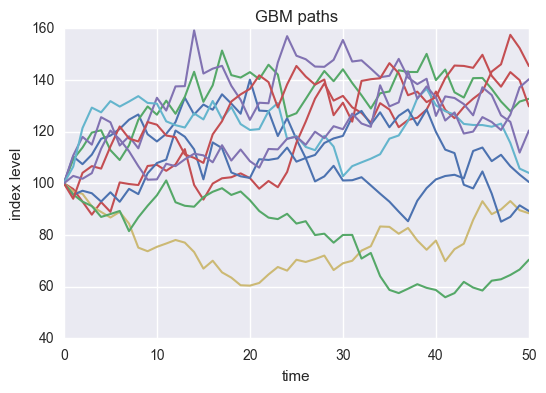

In [3]:
plt.plot(S_1[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
plt.title("GBM paths")
# tag: gbm_dt_paths
# title: Simulated geometric Brownian motion paths
# size: 60

Simulating geometric Brownian motion at maturity

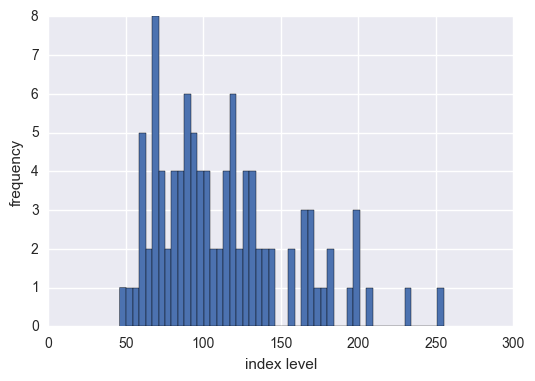

In [4]:
plt.hist(S_1[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)
# tag: gbm_dt_hist
# title: Simulated geometric Brownian motion at maturity
# size: 60

In [5]:
strike = np.linspace(50, 150, 24)
ttm = np.linspace(0.5, 2.5, 24)
strike, ttm = np.meshgrid(strike, ttm)


iv = (strike - 100) ** 2 / (100 * strike) / ttm
  # generate fake implied volatilities

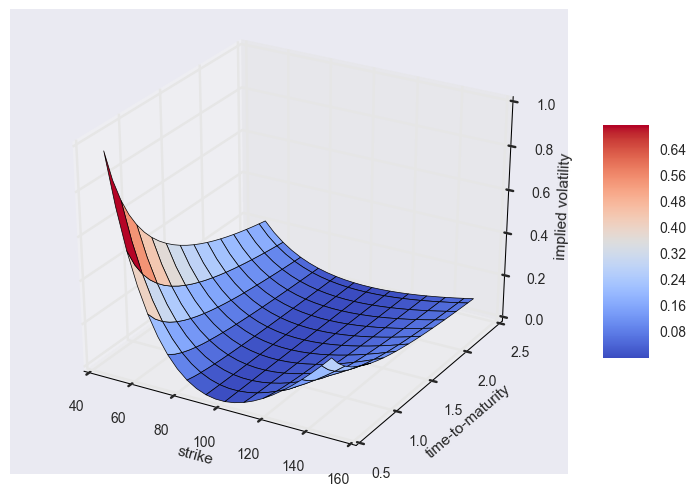

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(strike, ttm, iv, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_xlabel('strike')
ax.set_ylabel('time-to-maturity')
ax.set_zlabel('implied volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

# Titulo Maneiro

In [7]:
# Data simulation
S0, S0_ = 100, 100 # initial value
r = 0.05  # constant short rate
sigma1, sigma2 = 0.25, 0.25  # constant volatility
T = 2.0  # time in years
M = 50 # maturity
I = 100  # number of random draws

dt = T / M
S_1 = np.zeros((M + 1, I))
S_2 = np.zeros((M + 1, I))

S_1[0] = S0
S_2[0] = S0_

for t in range(1, M + 1):
    S_1[t] = S_1[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma1 * np.sqrt(dt) * npr.standard_normal(I))
    S_2[t] = S_2[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma2 * np.sqrt(dt) * npr.standard_normal(I))

S_12 = S_1 / S_2

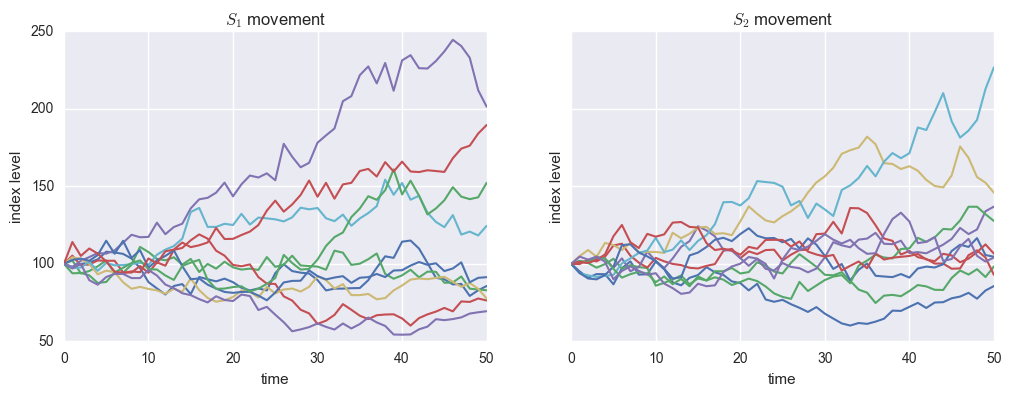

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(12, 4)

ax1.plot(S_1[:, :10], lw=1.5)
ax1.set_xlabel('time')
ax1.set_ylabel('index level')
ax1.set_title('$S_1$ movement')
ax1.grid(True)

ax2.plot(S_2[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('index level')
ax2.set_title('$S_2$ movement')
ax2.grid(True)

## Implementation of The Algorithm

In [9]:
from scipy.interpolate import interp1d
# Approximation of Delta dirac function
def delta(x):
    n = 100
    return n / (1 + (n * x) ** 2) / np.pi

### Local in cross volatility model
We are taking the case $\sigma_1 = \sigma_2 $ and $\rho=\dfrac{\sigma_1^2 + \sigma_2^2 - \sigma_{12}^2}{2 \sigma_1 \sigma_2}$ as described in the paper. $a = \sigma_1^2 + \sigma_2^2$ and $b = -2 \sigma_1 \sigma_2$

In [10]:
# Definition of Parameters
k = 1
sigma_12 = 0.5
sigma1, sigma2 = 0.25, 0.25
a = sigma1 ** 2 + sigma2 ** 2 
b = -2 * sigma1 * sigma2

N = 10 # grid
grilha = np.linspace(0,100, N)

In [11]:
def interp(p, f):
    x = p
    y = f
    f2 = interp1d(x, y, kind='cubic')
    return f2

In [12]:
# Algorithm
def calibrate(S_1, S_2, sigma1, sigma2, a, b, grilha):
    ind = 0
    rho = (sigma1**2 + sigma2**2 - sigma_12**2) / (2 * sigma1 * sigma2)
    Enum = np.zeros((N, M+1))
    Eden = np.zeros((N, M+1))
    f = np.zeros((N, M+1))
    for p in grilha:
        Enum[ind] = np.sum((S_2*(sigma1**2 + sigma2**2 + 2*(a/b)*sigma1*sigma2)) * delta(S_1/S_2 - p), axis = 1)/np.sum(S_2 * delta(S_1/S_2 - p), axis = 1)
        Eden[ind] = np.sum((S_2*(sigma1*sigma2)/b) * delta(S_1/S_2 - p), axis = 1)/np.sum(S_2 * delta(S_1/S_2 - p), axis = 1)
        f[ind] = (Enum[ind] - sigma_12**2)/(2*Eden[ind])
        ind+=1
        
    f2 = []
    for t in range(1, M + 1):
        f2.append(interp(grilha, f[:, t]))
    return f2

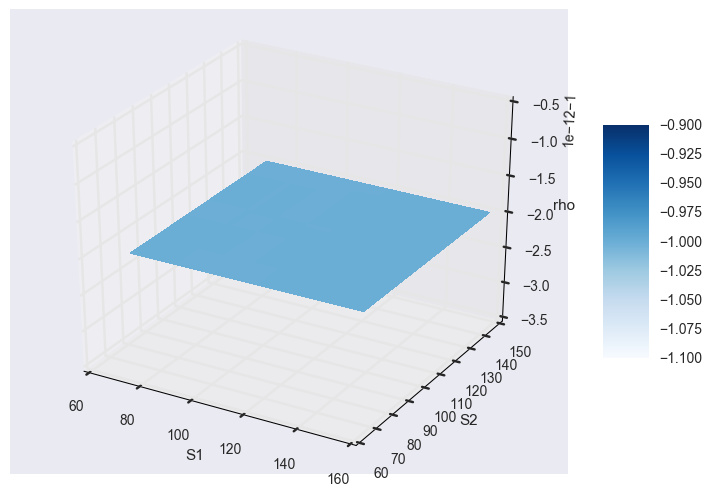

In [13]:
flist = calibrate(S_1, S_2, sigma1, sigma2, a, b, grilha)
t = 10
s1, s2 = np.meshgrid(S_1[t], S_2[t])
z = (1/b) * (flist[t](s1/s2) - a)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.Blues, linewidth=0,
                       antialiased=False)

ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

### Local in cross correlation model
We are taking  $a = 0$ and $b = 1$

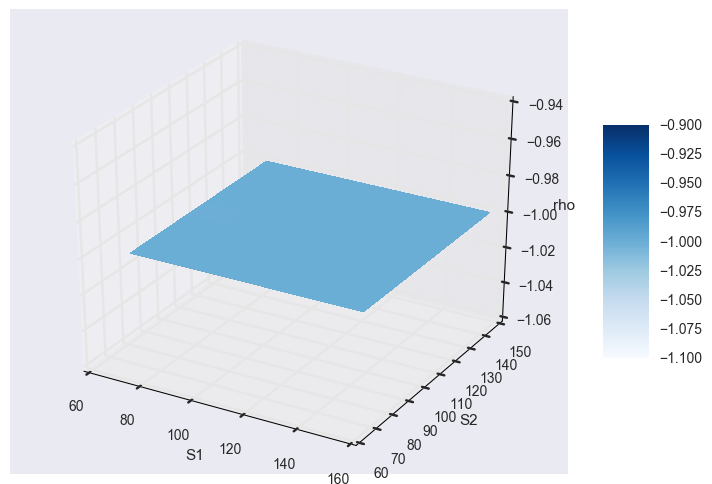

In [14]:
a,b = 0, 1
flist = calibrate(S_1, S_2, sigma1, sigma2, a, b, grilha)
t = 10
s1, s2 = np.meshgrid(S_1[t], S_2[t])
z = (1/b) * (flist[t](s1/s2) - a)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.Blues, linewidth=0,
                       antialiased=False)

ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

### Local in cross covariance model
We are taking  $a = 0$ and $b = \sigma_1 \sigma_2$

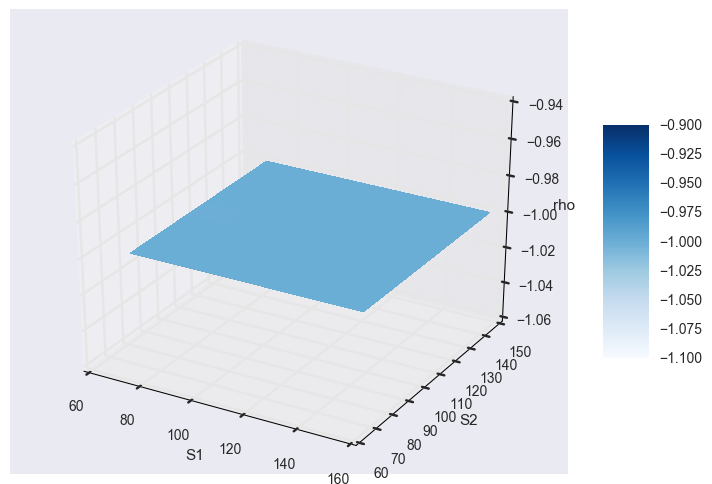

In [15]:
a, b = 0, sigma1 * sigma2
flist = calibrate(S_1, S_2, sigma1, sigma2, a, b, grilha)
t = 10
s1, s2 = np.meshgrid(S_1[t], S_2[t])
z = (1/b) * (flist[t](s1/s2) - a)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.Blues, linewidth=0,
                       antialiased=False)

ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

# Local Volatility Model
Here we discuss the model $\sigma(t,x) = \sigma (1 + e^{-(\lambda x + \mu x)})$.

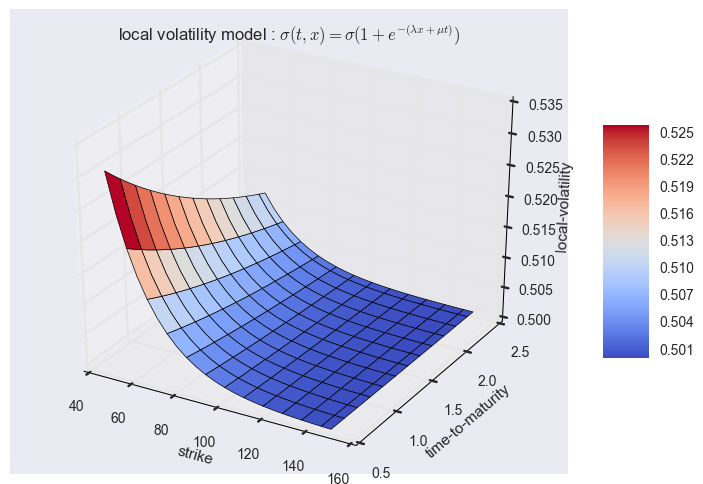

In [16]:
strike = np.linspace(50, 150, 24)
ttm = np.linspace(0.5, 2.5, 24)
strike, ttm = np.meshgrid(strike, ttm)


iv = 0.50 * (1 + np.exp(- 0.05 * strike - 0.5 * ttm))
  # generate fake implied volatilities
    
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(strike, ttm, iv, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_xlabel('strike')
ax.set_ylabel('time-to-maturity')
ax.set_zlabel('local-volatility')
ax.set_title(r'local volatility model : $\sigma(t,x) = \sigma (1 + e^{-(\lambda x + \mu t)})$')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

For the Triangle model : 
\begin{align}
	d S_t^1 &= (r_t^d - r_t^1)S_t^1 \:dt + \sigma_1(t,S_t^1)S_t^1\:dW_t^1 \nonumber\\
    d S_t^2 &= (r_t^d - r_t^2)S_t^2 \:dt + \sigma_2(t,S_t^2)S_t^2\:dW_t^2 \nonumber\\
    d \left\langle W^1,W^2 \right\rangle_t &= \rho(t,S_t^1,S_t^2)\: dt 
\end{align}

We start by simulating $S_1, S_2$ and $S_{12}$

In [17]:
# Data simulation
S0, S0_, S0__ = 110, 105, 1.05 # initial value
r1, r2, rd = 0.5, 0.8, 0.6  # constant short rate

# local volatilities
def sigma1(t,x):
    aux = (x - 100) ** 2 / (90 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)
def sigma2(t,x):
    aux = (x - 95) ** 2 / (80 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)
def sigma12(t,x):
    aux = (x - 0.5) ** 2 / (2 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)
def ro(t,x1,x2):
    aux = (sigma1(t,x1)**2 + sigma2(t,x2)**2 - sigma12(t,x1/x2)**2) / (2 * sigma1(t,x1) * sigma2(t,x2) + 0.2)
    return np.minimum(np.maximum(aux, np.ones(x1.shape)* -1), np.ones(x1.shape)* 1)
T = 2.5  # time in years
M = 50 # maturity
I = 1000  # number of random draws

dt = T / M
S_1 = np.zeros((M + 1, I))
S_2 = np.zeros((M + 1, I))
S_12 = np.zeros((M + 1, I))

S_1[0] = S0
S_2[0] = S0_
S_12[0] = S0__

for t in range(1, M + 1):
    ttm = (M - t) * T / M
    rh = ro(ttm, S_1[t - 1], S_2[t - 1])
    W1 = npr.standard_normal(I)
    W2 = rh * W1 + np.sqrt(1-rh**2) * npr.standard_normal(I)
    
    S_1[t] = S_1[t - 1] * np.exp((rd-r1) * dt + sigma1(ttm, S_1[t - 1]) * np.sqrt(dt) * W1)
    S_2[t] = S_2[t - 1] * np.exp((rd-r2) * dt + sigma2(ttm, S_2[t - 1]) * np.sqrt(dt) * W2)
    S_12[t] = S_12[t - 1] * np.exp((r2-r1) * dt + sigma1(ttm, S_1[t - 1]) * np.sqrt(dt) * W1 - sigma2(ttm, S_2[t - 1]) * np.sqrt(dt) * W2)

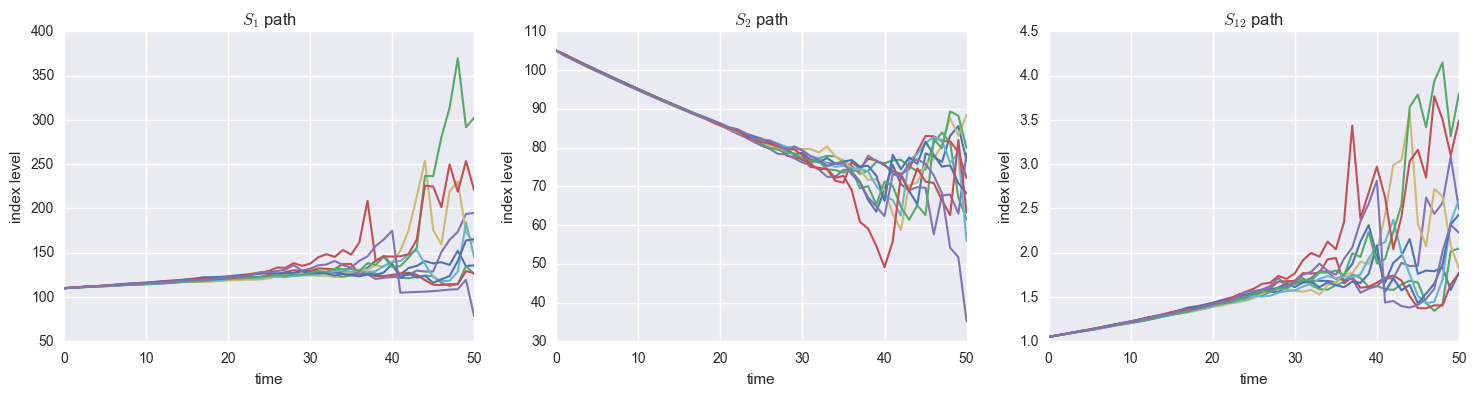

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
f.set_size_inches(18, 4)

ax1.plot(S_1[:, :10], lw=1.5)
ax1.set_xlabel('time')
ax1.set_ylabel('index level')
ax1.set_title('$S_1$ path')
ax1.grid(True)

ax2.plot(S_2[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('index level')
ax2.set_title('$S_2$ path')
ax2.grid(True)

ax3.plot(S_12[:, :10], lw=1.5)
ax3.set_xlabel('time')
ax3.set_ylabel('index level')
ax3.set_title('$S_{12}$ path')
ax3.grid(True)

## Particle Method Implementetion
Here we improve our old algorithm to apply it to non constant volatilities

In [19]:
# Algorithm
N = 500 # grid
grilha = np.linspace(0.01, 4, N)

def particle_method(S_1, S_2, S_12, sigma1, sigma2, sigma12, a, b, grilha):
    ind = 0
    Enum = np.zeros((N, M+1))
    Eden = np.zeros((N, M+1))
    f = np.zeros((N, M+1))
    for p in grilha:
        ttm = (M - ind) * T / M
        Enum[ind] = np.sum((S_2*(sigma1(ttm, S_1)**2 + \
                                 sigma2(ttm, S_2)**2 + 2*(a(ttm, S_1, S_2) / b(ttm, S_1, S_2))\
                                 *sigma1(ttm, S_1)*sigma2(ttm, S_2)))  \
                           * delta(S_1/S_2 - p), axis = 1) / np.sum(S_2 * delta(S_1/S_2 - p), axis = 1)
        Eden[ind] = np.sum((S_2*(sigma1(ttm, S_1)*sigma2(ttm, S_2))/b(ttm, S_1, S_2)) * \
                           delta(S_1/S_2 - p), axis = 1)/np.sum(S_2 * delta(S_1/S_2 - p), axis = 1)
        f[ind] = (Enum[ind] - sigma12(ttm, p)**2 * np.ones(M+1))/(2*Eden[ind])
        ind+=1
        
    f2 = []
    for t in range(1, M + 1):
        f2.append(interp(grilha, f[:, t]))
    return f2

## Model local in cross correlation
We take $a = 0$ and $b = 1$

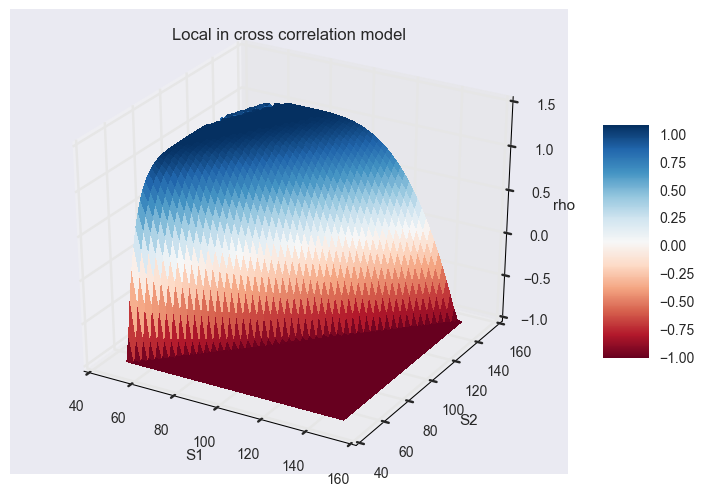

In [20]:
def a(t,x1,x2):
    return 0
def b(t,x1,x2):
    return 1

flist = particle_method(S_1, S_2, S_12, sigma1, sigma2, sigma12, a, b, grilha)
t = 30
ttm = (M - t) * T / M

#x, y = S_1[t], S_2[t]
x = np.linspace(50, 150, 50)
y = np.linspace(50, 150, 50)
s1, s2 = np.meshgrid(x, y)
#s1, s2 = np.meshgrid(x[x<150], y[y<150])
z = (1/b(ttm, s1, s2)) * (flist[t](s1/s2) - a(ttm, s1, s2))
z = np.maximum(z,-1)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.RdBu, linewidth=0,
                       antialiased=False)
ax.set_title(r'Local in cross correlation model')
#ax.set_zlim([-1,1])
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

## Model local in cross volatility
We take $a = \sigma_1^2 + \sigma_2^2$ and $b = - 2 \sigma_1 \sigma_2$

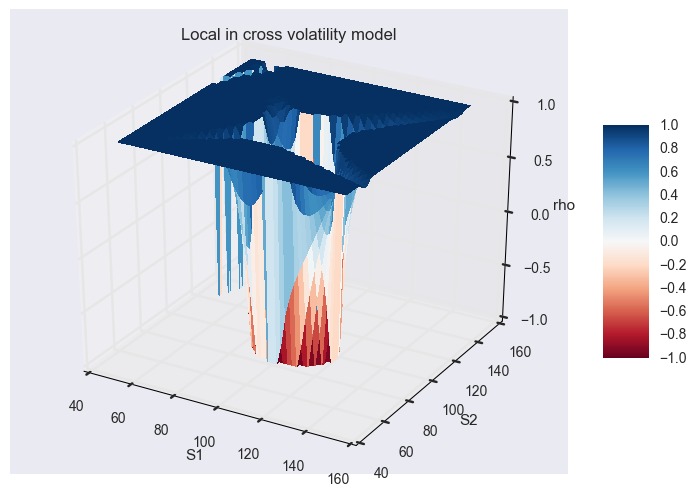

In [21]:
def a(t,x1,x2):
    return sigma1(t,x1) ** 2 + sigma2(t,x2)**2
def b(t,x1,x2):
    return - 2 * sigma1(t,x1) * sigma2(t,x2)

flist = particle_method(S_1, S_2, S_12, sigma1, sigma2, sigma12, a, b, grilha)
t = 30
ttm = (M - t) * T / M

#x, y = S_1[t], S_2[t]
x = np.linspace(50, 150, 50)
y = np.linspace(50, 150, 50)
s1, s2 = np.meshgrid(x, y)
#s1, s2 = np.meshgrid(x[x<150], y[y<150])
z = (1/b(ttm, s1, s2)) * (flist[t](s1/s2) - a(ttm, s1, s2))
z = np.minimum(np.maximum(z,-1),1)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.RdBu, linewidth=0,
                       antialiased=False)
ax.set_title(r'Local in cross volatility model')
#ax.set_zlim([-1,1])
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

## Model local in cross covariance
We take $a = 0$ and $b = \sigma_1 \sigma_2$

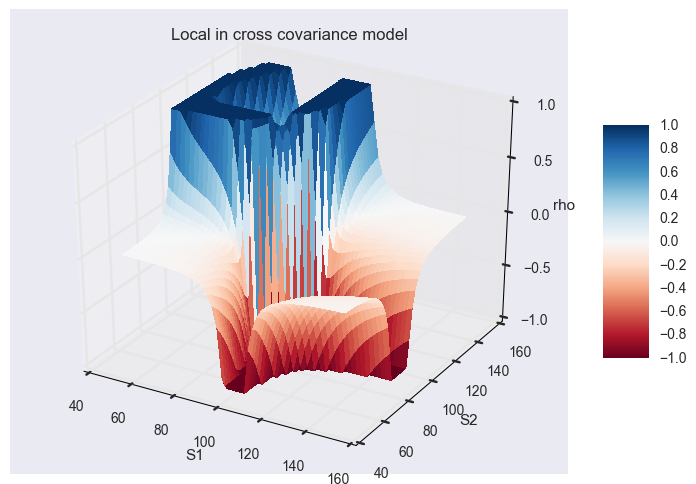

In [22]:
def a(t,x1,x2):
    return 0
def b(t,x1,x2):
    return sigma1(t,x1) * sigma2(t,x2)

flist = particle_method(S_1, S_2, S_12, sigma1, sigma2, sigma12, a, b, grilha)
t = 30
ttm = (M - t) * T / M

#x, y = S_1[t], S_2[t]
x = np.linspace(50, 150, 50)
y = np.linspace(50, 150, 50)
s1, s2 = np.meshgrid(x, y)
#s1, s2 = np.meshgrid(x[x<150], y[y<150])
z = (1/b(ttm, s1, s2)) * (flist[t](s1/s2) - a(ttm, s1, s2))
z = np.minimum(np.maximum(z,-1),1)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(s1, s2, z, rstride=1, cstride=1,
                       cmap=plt.cm.RdBu, linewidth=0,
                       antialiased=False)
ax.set_title(r'Local in cross covariance model')
#ax.set_zlim([-1,1])
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)

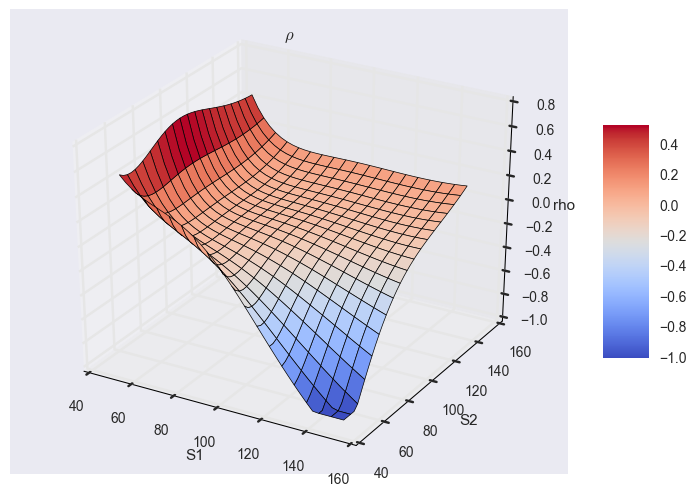

In [23]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

def ro(t,x1,x2):
    aux = (sigma1(t,x1)**2 + sigma2(t,x2)**2 - sigma12(t,x1/x2)**2) / (2 * sigma1(t,x1) * sigma2(t,x2) + 0.2)
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x1.shape)* 1)

t = 20
ttm = (M - t) * T / M
x = np.linspace(50, 150, 37)
y = np.linspace(50, 150, 37)
s1, s2 = np.meshgrid(x, y)
z = ro(ttm, s1, s2)

surf = ax.plot_surface(s1, s2, z, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_title(r'$\rho$')
#ax.set_zlim([-1,1])
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('rho')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

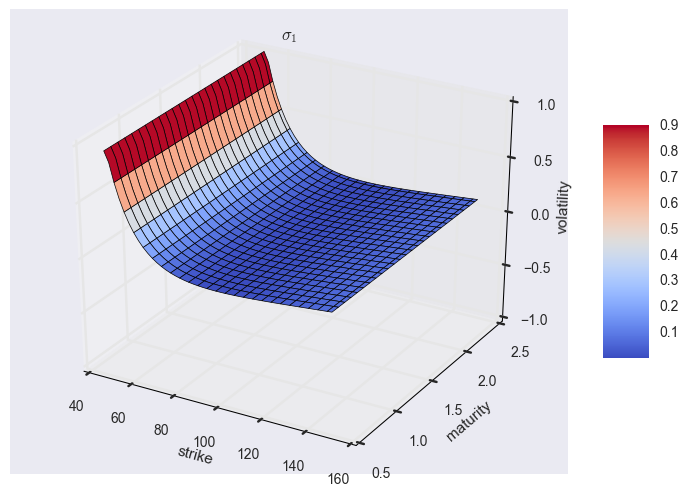

In [24]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

def sigma1(t,x):
    aux = (x - 100) ** 2 / (90 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)

x = np.linspace(50, 150, 50)
t = np.linspace(0.5, 2.5, 50)
s1, s2 = np.meshgrid(x, t)

z = sigma1(t, x)

surf = ax.plot_surface(s1, s2, z, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_title(r'$\sigma_1$')
ax.set_zlim([-1,1])
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel(r'volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

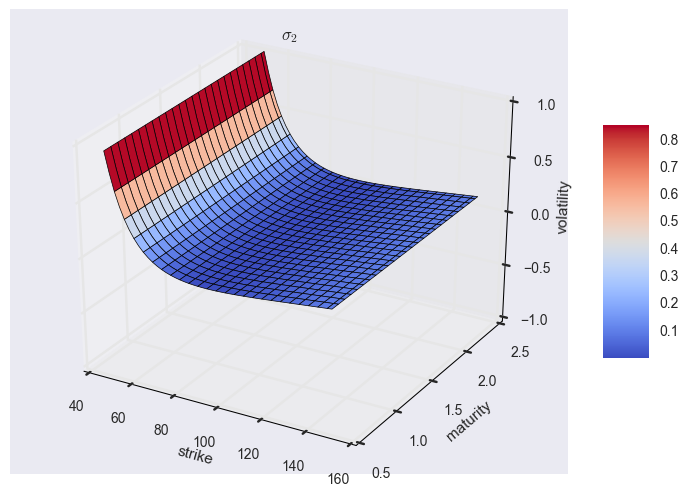

In [25]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

def sigma2(t,x):
    aux = (x - 95) ** 2 / (80 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)


x = np.linspace(50, 150, 50)
t = np.linspace(0.5, 2.5, 50)
s1, s2 = np.meshgrid(x, t)
z = sigma2(t, x)

surf = ax.plot_surface(s1, s2, z, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_title(r'$\sigma_2$')
ax.set_zlim([-1,1])
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel(r'volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

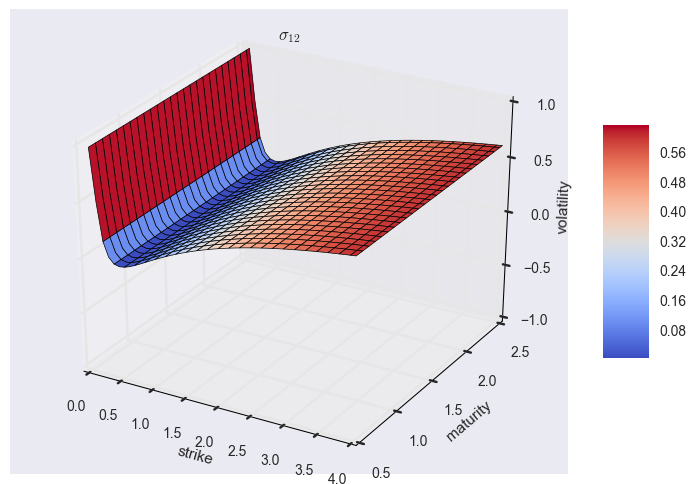

In [26]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

def sigma12(t,x):
    aux = (x - 0.5) ** 2 / (2 * x) / t
    return np.minimum(np.maximum(aux, np.ones(x.shape)* -1), np.ones(x.shape)* 1)

x = np.linspace(0.1, 4, 50)
t = np.linspace(0.5, 2.5, 50)
s1, s2 = np.meshgrid(x, t)
z = sigma12(t, x)

surf = ax.plot_surface(s1, s2, z, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_title(r'$\sigma_{12}$')
ax.set_zlim([-1,1])
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel(r'volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70

## Spline interpolation

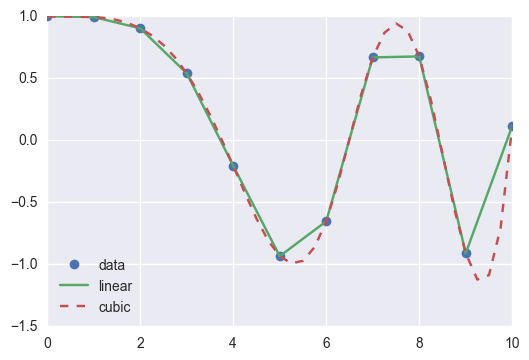

In [27]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()